<a href="https://colab.research.google.com/github/martin-fabbri/colab-notebooks/blob/master/Bayesian_Linear_Regression_With_TFP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Imports and Global Variables  { display-mode: "form" }
"""
The book uses a custom matplotlibrc file, which provides the unique styles for
matplotlib plots. If executing this book, and you wish to use the book's
styling, provided are two options:
    1. Overwrite your own matplotlibrc file with the rc-file provided in the
       book's styles/ dir. See http://matplotlib.org/users/customizing.html
    2. Also in the styles is  bmh_matplotlibrc.json file. This can be used to
       update the styles in only this notebook. Try running the following code:

        import json
        s = json.load(open("../styles/bmh_matplotlibrc.json"))
        matplotlib.rcParams.update(s)
"""
!pip3 install -q wget
from __future__ import absolute_import, division, print_function

#@markdown This sets the warning status (default is `ignore`, since this notebook runs correctly)
warning_status = "ignore" #@param ["ignore", "always", "module", "once", "default", "error"]
import warnings
warnings.filterwarnings(warning_status)
with warnings.catch_warnings():
    warnings.filterwarnings(warning_status, category=DeprecationWarning)
    warnings.filterwarnings(warning_status, category=UserWarning)

import numpy as np
import os
#@markdown This sets the styles of the plotting (default is styled like plots from [FiveThirtyeight.com](https://fivethirtyeight.com/))
matplotlib_style = 'fivethirtyeight' #@param ['fivethirtyeight', 'bmh', 'ggplot', 'seaborn', 'default', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-colorblind', 'seaborn-notebook']
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn as sns; sns.set_context('notebook')
from scipy.optimize import fmin
from IPython.core.pylabtools import figsize
#@markdown This sets the resolution of the plot outputs (`retina` is the highest resolution)
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
%config InlineBackend.figure_format = notebook_screen_res

import tensorflow as tf
tfe = tf.contrib.eager

# Eager Execution
#@markdown Check the box below if you want to use [Eager Execution](https://www.tensorflow.org/guide/eager)
#@markdown Eager execution provides An intuitive interface, Easier debugging, and a control flow comparable to Numpy. You can read more about it on the [Google AI Blog](https://ai.googleblog.com/2017/10/eager-execution-imperative-define-by.html)
use_tf_eager = False #@param {type:"boolean"}

# Use try/except so we can easily re-execute the whole notebook.
if use_tf_eager:
    try:
        tf.enable_eager_execution()
    except:
        pass

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

  
def evaluate(tensors):
    """Evaluates Tensor or EagerTensor to Numpy `ndarray`s.
    Args:
    tensors: Object of `Tensor` or EagerTensor`s; can be `list`, `tuple`,
      `namedtuple` or combinations thereof.

    Returns:
      ndarrays: Object with same structure as `tensors` except with `Tensor` or
        `EagerTensor`s replaced by Numpy `ndarray`s.
    """
    if tf.executing_eagerly():
        return tf.contrib.framework.nest.pack_sequence_as(
            tensors,
            [t.numpy() if tf.contrib.framework.is_tensor(t) else t
             for t in tf.contrib.framework.nest.flatten(tensors)])
    return sess.run(tensors)

class _TFColor(object):
    """Enum of colors used in TF docs."""
    red = '#F15854'
    blue = '#5DA5DA'
    orange = '#FAA43A'
    green = '#60BD68'
    pink = '#F17CB0'
    brown = '#B2912F'
    purple = '#B276B2'
    yellow = '#DECF3F'
    gray = '#4D4D4D'
    def __getitem__(self, i):
        return [
            self.red,
            self.orange,
            self.green,
            self.blue,
            self.pink,
            self.brown,
            self.purple,
            self.yellow,
            self.gray,
        ][i % 9]
TFColor = _TFColor()

def session_options(enable_gpu_ram_resizing=True, enable_xla=True):
    """
    Allowing the notebook to make use of GPUs if they're available.
    
    XLA (Accelerated Linear Algebra) is a domain-specific compiler for linear 
    algebra that optimizes TensorFlow computations.
    """
    config = tf.ConfigProto()
    config.log_device_placement = True
    if enable_gpu_ram_resizing:
        # `allow_growth=True` makes it possible to connect multiple colabs to your
        # GPU. Otherwise the colab malloc's all GPU ram.
        config.gpu_options.allow_growth = True
    if enable_xla:
        # Enable on XLA. https://www.tensorflow.org/performance/xla/.
        config.graph_options.optimizer_options.global_jit_level = (
            tf.OptimizerOptions.ON_1)
    return config


def reset_sess(config=None):
    """
    Convenience function to create the TF graph & session or reset them.
    """
    if config is None:
        config = session_options()
    global sess
    tf.reset_default_graph()
    try:
        sess.close()
    except:
        pass
    sess = tf.InteractiveSession(config=config)

reset_sess()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



# Bayesian Linear Regression
In a Bayesian linear regression, we assign a likelihood function for Y~ Normal (𝛍, 𝛔)  where 𝛍 = 𝛂 + 𝛃 X. Note that this is the same function as the standard linear regression model. However, we treat parameters 𝛂, 𝛃 and 𝛔 as random variables with probability distributions. Data of excess returns Y = (R-F) and X = (M - F) are treated as fixed. We then use Bayes’ theorem to figure out the posterior distributions for 𝛂, 𝛃, and 𝛔:

**P(𝛂, 𝛃, 𝛔| Y, X) = P(Y| 𝛂, 𝛃, 𝛔, X) P(𝛂, 𝛃, 𝛔|X)/P(Y|X)**

We need to assign prior probability distributions to all parameters: 
𝛂 ~ Normal (a, b),  𝛃 ~ Normal (c, d), 𝛔 ~ Uniform (e, f). Prior distributions depend on your previous knowledge/hypotheses about parameters. 

After building the model with the prior distributions and the likelihood function, we use the Hamiltonian Monte Carlo algorithm to sample from the posterior distribution.


# Import your data

In [2]:
import statsmodels.api as sm
import pandas_datareader.data as pdr
import fix_yahoo_finance as yf
yf.pdr_override()
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from datetime import datetime



start = datetime(2018, 9, 13)
end = datetime(2019, 9, 13)

riskfree_rate = pdr.DataReader('TB4WK', 'fred', start, end)
market = pdr.get_data_yahoo('SPY', start, end)
stock = pdr.get_data_yahoo('AAPL', start, end)

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded


# Explore your data

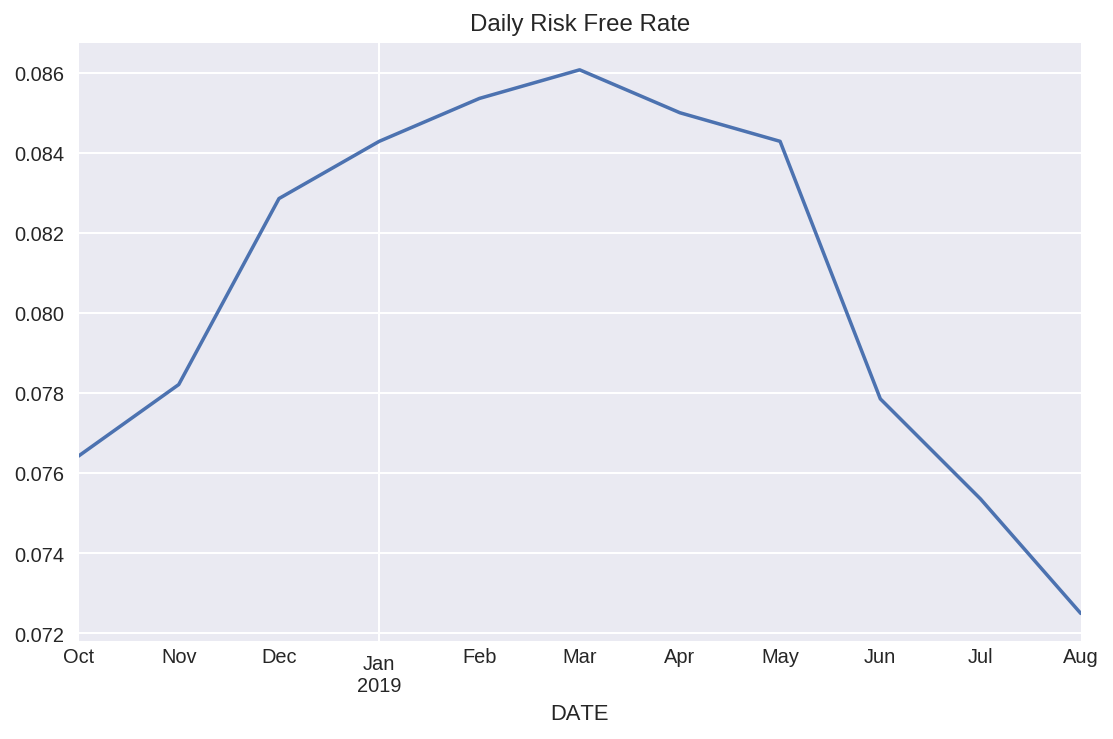

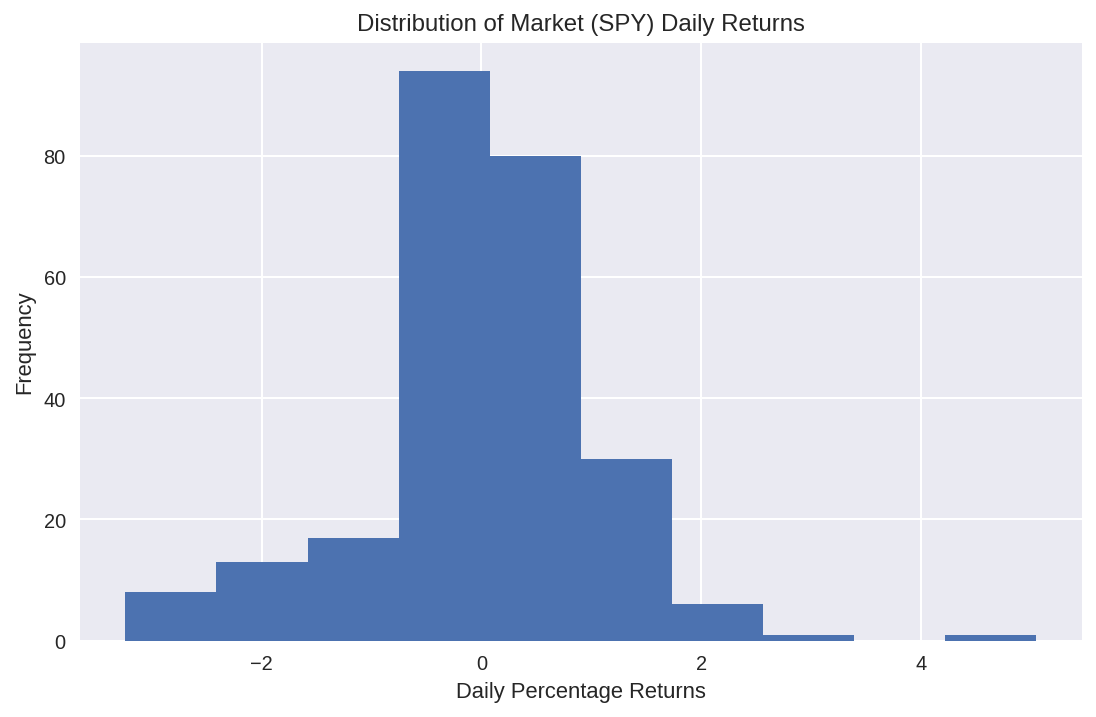

Descriptive Stastics of the Market's daily percentage returns:
count    250.000000
mean       0.027516
std        1.054556
min       -3.240233
25%       -0.385208
50%        0.050687
75%        0.623282
max        5.052480
Name: Adj Close, dtype: float64


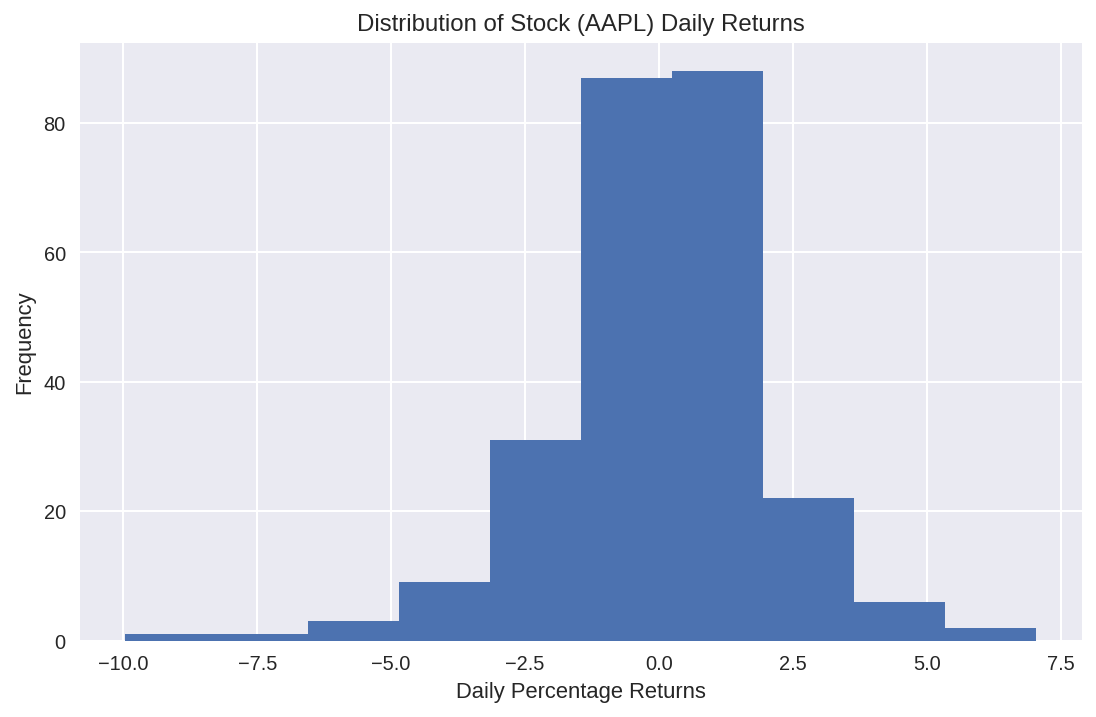

Descriptive stastics of Apple stock's percentage returns:
count    250.000000
mean       0.020877
std        2.026331
min       -9.960742
25%       -0.910270
50%        0.115801
75%        1.115335
max        7.042150
Name: Adj Close, dtype: float64


In [3]:
riskfree_scaling = 28 #Need to scale the risk free rate by its maturity to get the daily risk free rate
riskfree_rate = riskfree_rate['TB4WK'].dropna()/riskfree_scaling
riskfree_rate.plot(), plt.title('Daily Risk Free Rate'), plt.show()

market_return = market['Adj Close'].pct_change(1)*100
market_return = market_return.dropna()
plt.hist(market_return), plt.title('Distribution of Market (SPY) Daily Returns'), plt.xlabel('Daily Percentage Returns'), plt.ylabel('Frequency'), plt.show()
print("Descriptive Stastics of the Market's daily percentage returns:\n{}".format(market_return.describe()))

stock_return = stock['Adj Close'].pct_change(1)*100
stock_return = stock_return.dropna()
plt.hist(stock_return), plt.title('Distribution of Stock (AAPL) Daily Returns'), plt.xlabel('Daily Percentage Returns'), plt.ylabel('Frequency'), plt.show()
print("Descriptive stastics of Apple stock's percentage returns:\n{}".format(stock_return.describe()))

# Pull data into tensors

In [0]:
stock_return_vals_ = stock_return.values
stock_return_vals =  tf.convert_to_tensor(stock_return_vals_, dtype=tf.float32)
market_return_vals_ = market_return.values
market_return_vals = tf.convert_to_tensor(market_return_vals_, dtype=tf.float32)

# Build your model

In [0]:
# we use this later to set the initial chain state for HMC for sigma
obs_stdev = tf.sqrt(
        tf.reduce_mean(tf.squared_difference(stock_return_vals_, tf.reduce_mean(stock_return_vals_, axis=0)),
                      axis=0))


def joint_log_prob(X_data_, Y_data_, alpha, beta, sigma):
    """
    Our posterior log probability, as a function of states
    
    Args:
      alpha_: scalar, taken from state of the HMC. y-intercept
      beta_: scalar, taken from state of the HMC. slope
      sigma_: scalar, the standard deviation of , taken from state of the HMC
    Returns: 
      Scalar sum of log probabilities
    Closure over: Y_data, X_data
    """
    
    # create random variables for priors for sigma, alpha, and beta
    rv_std = tfd.Uniform(name="std", low=0., high=100.)
    rv_beta = tfd.Normal(name="beta", loc=0., scale=100.)
    rv_alpha = tfd.Normal(name="alpha", loc=0., scale=100.)
    
    
    mean = alpha + beta * X_data_
    rv_observed = tfd.Normal(name="obs", loc=mean, scale=sigma)
    
    return (
        rv_alpha.log_prob(alpha) 
        + rv_beta.log_prob(beta) 
        + rv_std.log_prob(sigma)
        + tf.reduce_sum(rv_observed.log_prob(Y_data_))
    )

# Sample from your posterior distribution using Hamiltonian Monte Carlo

In [0]:
number_of_steps = 10000
burnin = 1000

# Set the chain's start state.
initial_chain_state = [
    tf.cast(x=1.,dtype=tf.float32) * tf.ones([], name='init_alpha', dtype=tf.float32),
    tf.cast(x=0.01,dtype=tf.float32) * tf.ones([], name='init_beta', dtype=tf.float32),
    tf.cast(x=obs_stdev,dtype=tf.float32) * tf.ones([], name='init_sigma', dtype=tf.float32)
]

# Since HMC operates over unconstrained space, we need to transform the
# samples so they live in real-space.
unconstraining_bijectors = [
    tfp.bijectors.Identity(),
    tfp.bijectors.Identity(),
    tfp.bijectors.Identity()
]

# Define a closure over our joint_log_prob.
unnormalized_posterior_log_prob = lambda *args: joint_log_prob(market_return_vals_,stock_return_vals_, *args)

# Initialize the step_size. (It will be automatically adapted.)
with tf.variable_scope(tf.get_variable_scope(), reuse=tf.AUTO_REUSE):
    step_size = tf.get_variable(
        name='step_size',
        initializer=tf.constant(0.5, dtype=tf.float32),
        trainable=False,
        use_resource=True
    )
kernel = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn=unnormalized_posterior_log_prob,num_leapfrog_steps=2,step_size=step_size)
hmc = tfp.mcmc.SimpleStepSizeAdaptation(inner_kernel=kernel, num_adaptation_steps=int(burnin * 0.9))
# Sampling from the chain.
[
    alpha,
    beta,
    sigma
], kernel_results = tfp.mcmc.sample_chain(
    num_results = number_of_steps,
    num_burnin_steps = burnin, # HMC gets rid of our burnin iterations automatically
    current_state=initial_chain_state,
    kernel=hmc,
    name='HMC_sampling'
) 
# Initialize any created variables for preconditions
init_g = tf.global_variables_initializer()

# Evaluate the graph

In [15]:
evaluate(init_g)
  
[
    alpha_,
    beta_,
    sigma_,
    kernel_results_
] = evaluate([
    alpha,
    beta,
    sigma,
    kernel_results
])

print("acceptance rate: {}".format(
    kernel_results_.inner_results.is_accepted.mean()))
#print("final step size: {}".format(
#    kernel_results_.inner_results.extra.step_size_assign[-100:].mean()))

acceptance rate: 0.6964


# Analyze the convergence of HMC

Text(0.5, 1.0, 'HMC alpha (α) convergence progression')

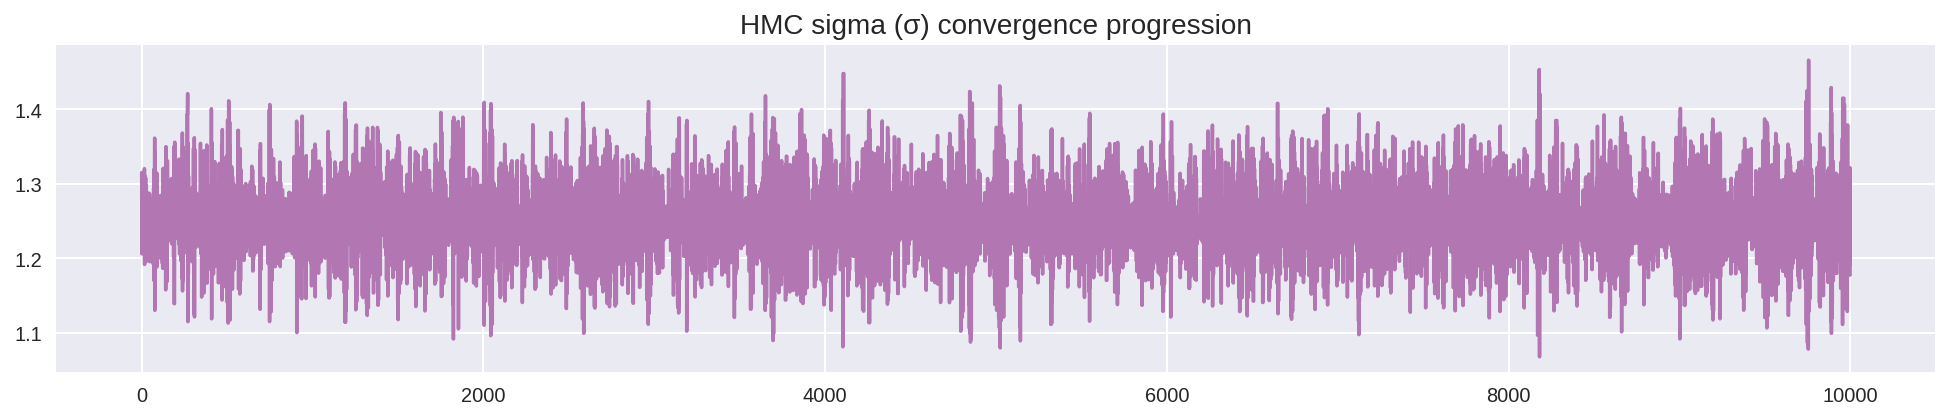

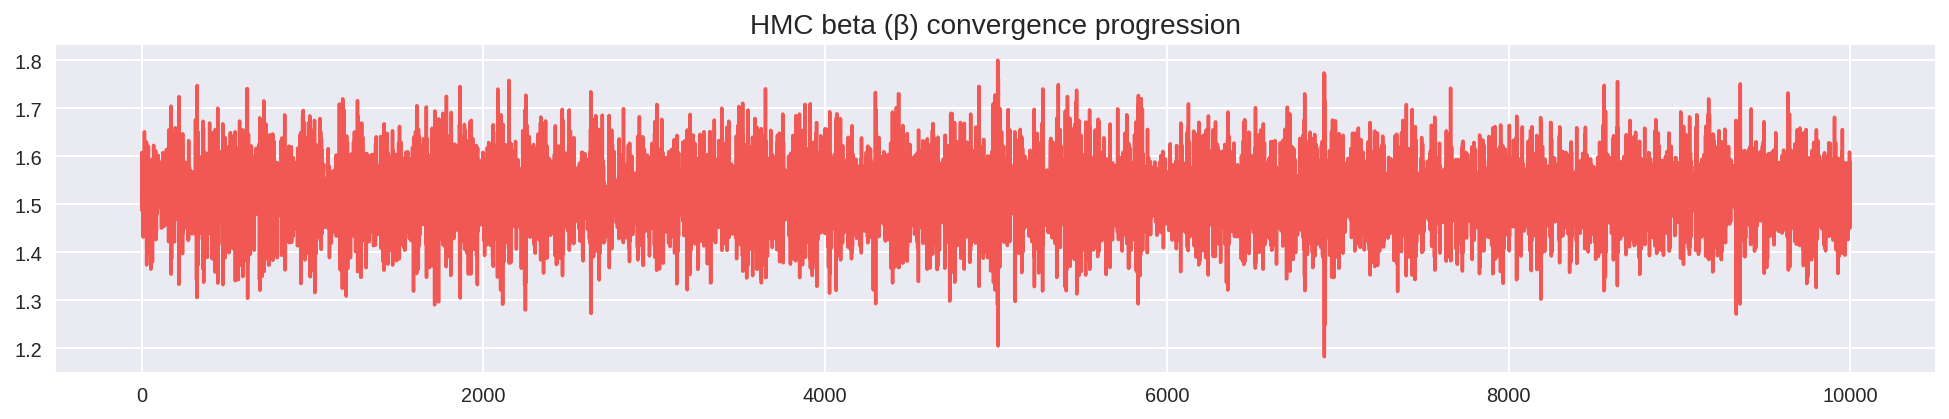

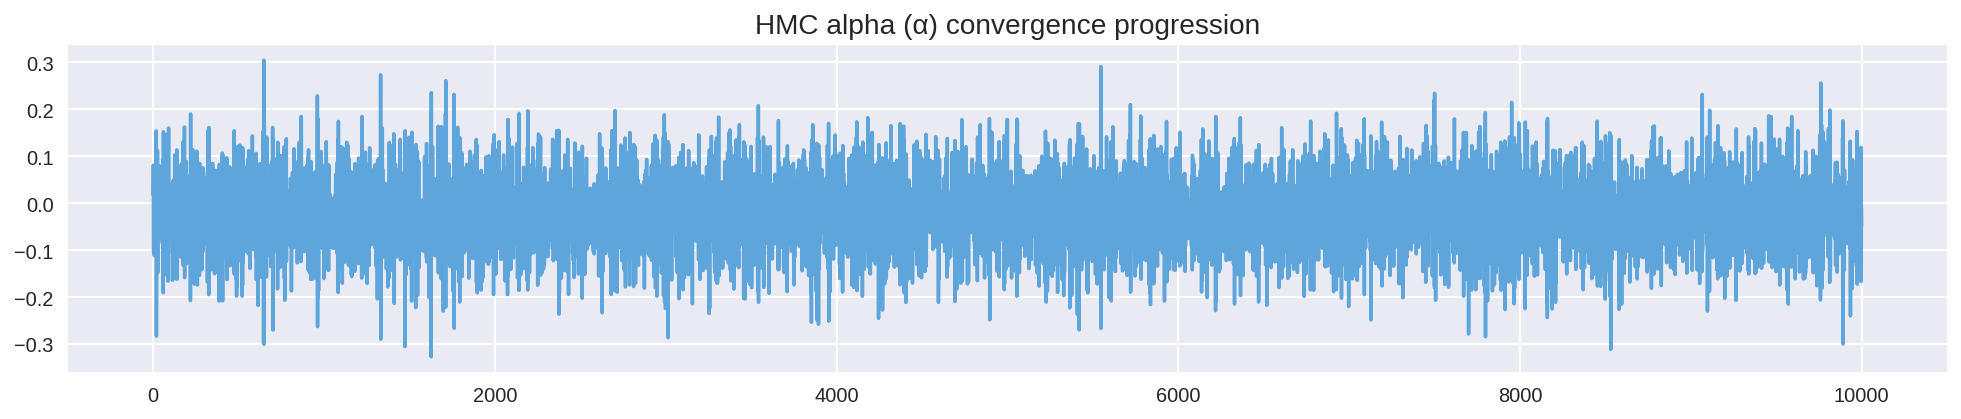

In [16]:
plt.figure(figsize=(15,3))
plt.plot(np.arange(number_of_steps), sigma_, color=TFColor[6])
plt.title('HMC sigma (σ) convergence progression', fontsize=14)

plt.figure(figsize=(15,3))
plt.plot(np.arange(number_of_steps), beta_, color=TFColor[0])
plt.title('HMC beta (β) convergence progression', fontsize=14)

plt.figure(figsize=(15,3))
plt.plot(np.arange(number_of_steps), alpha_, color=TFColor[3])
plt.title('HMC alpha (α) convergence progression', fontsize=14)


Text(0.5, 1.0, 'KDE plot for alpha (α) samples')

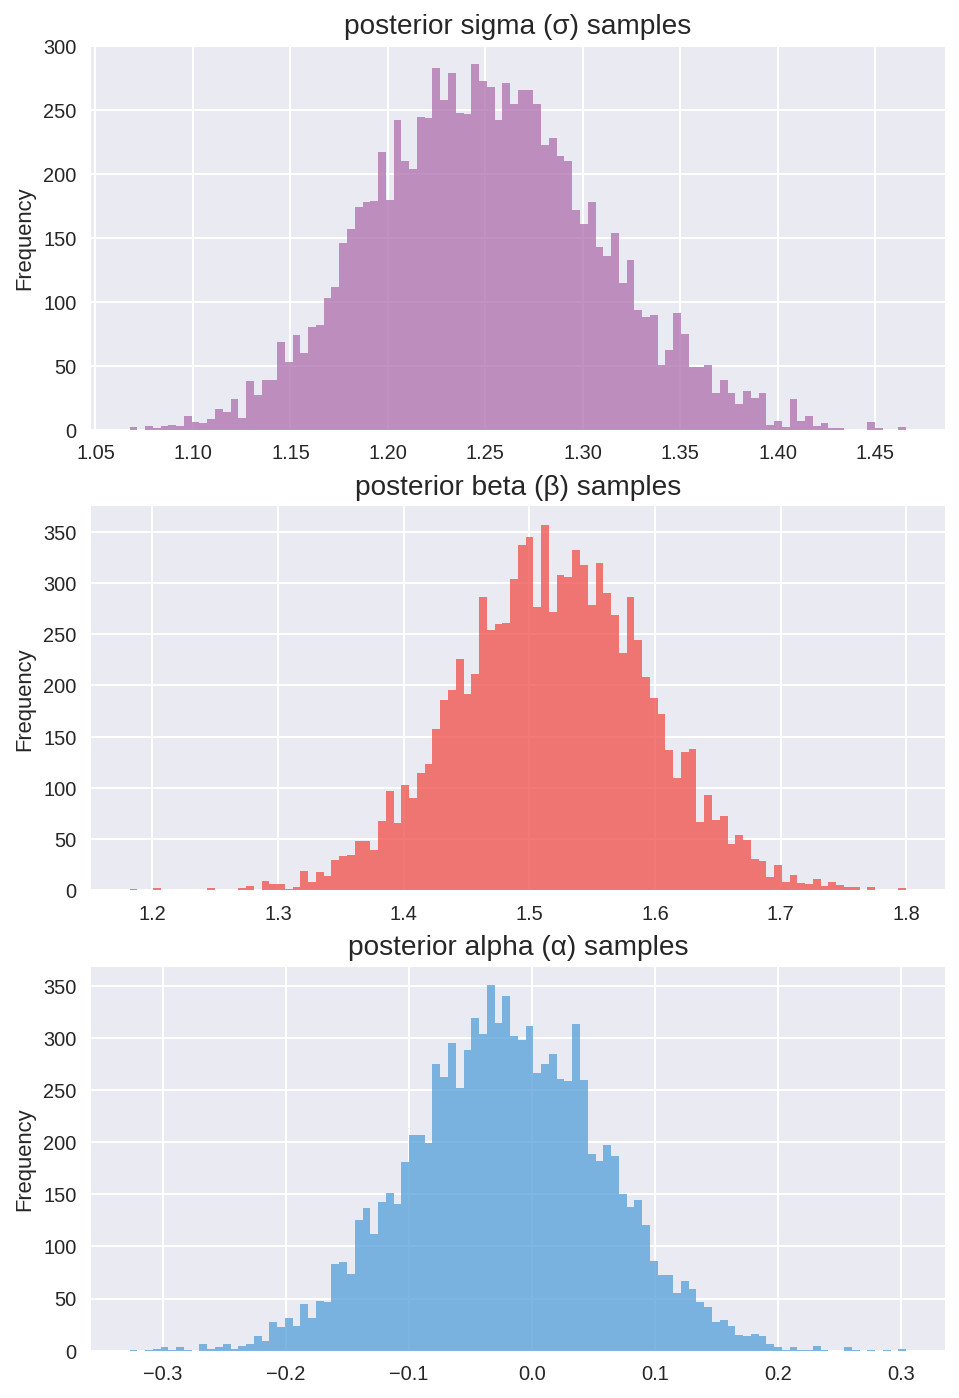

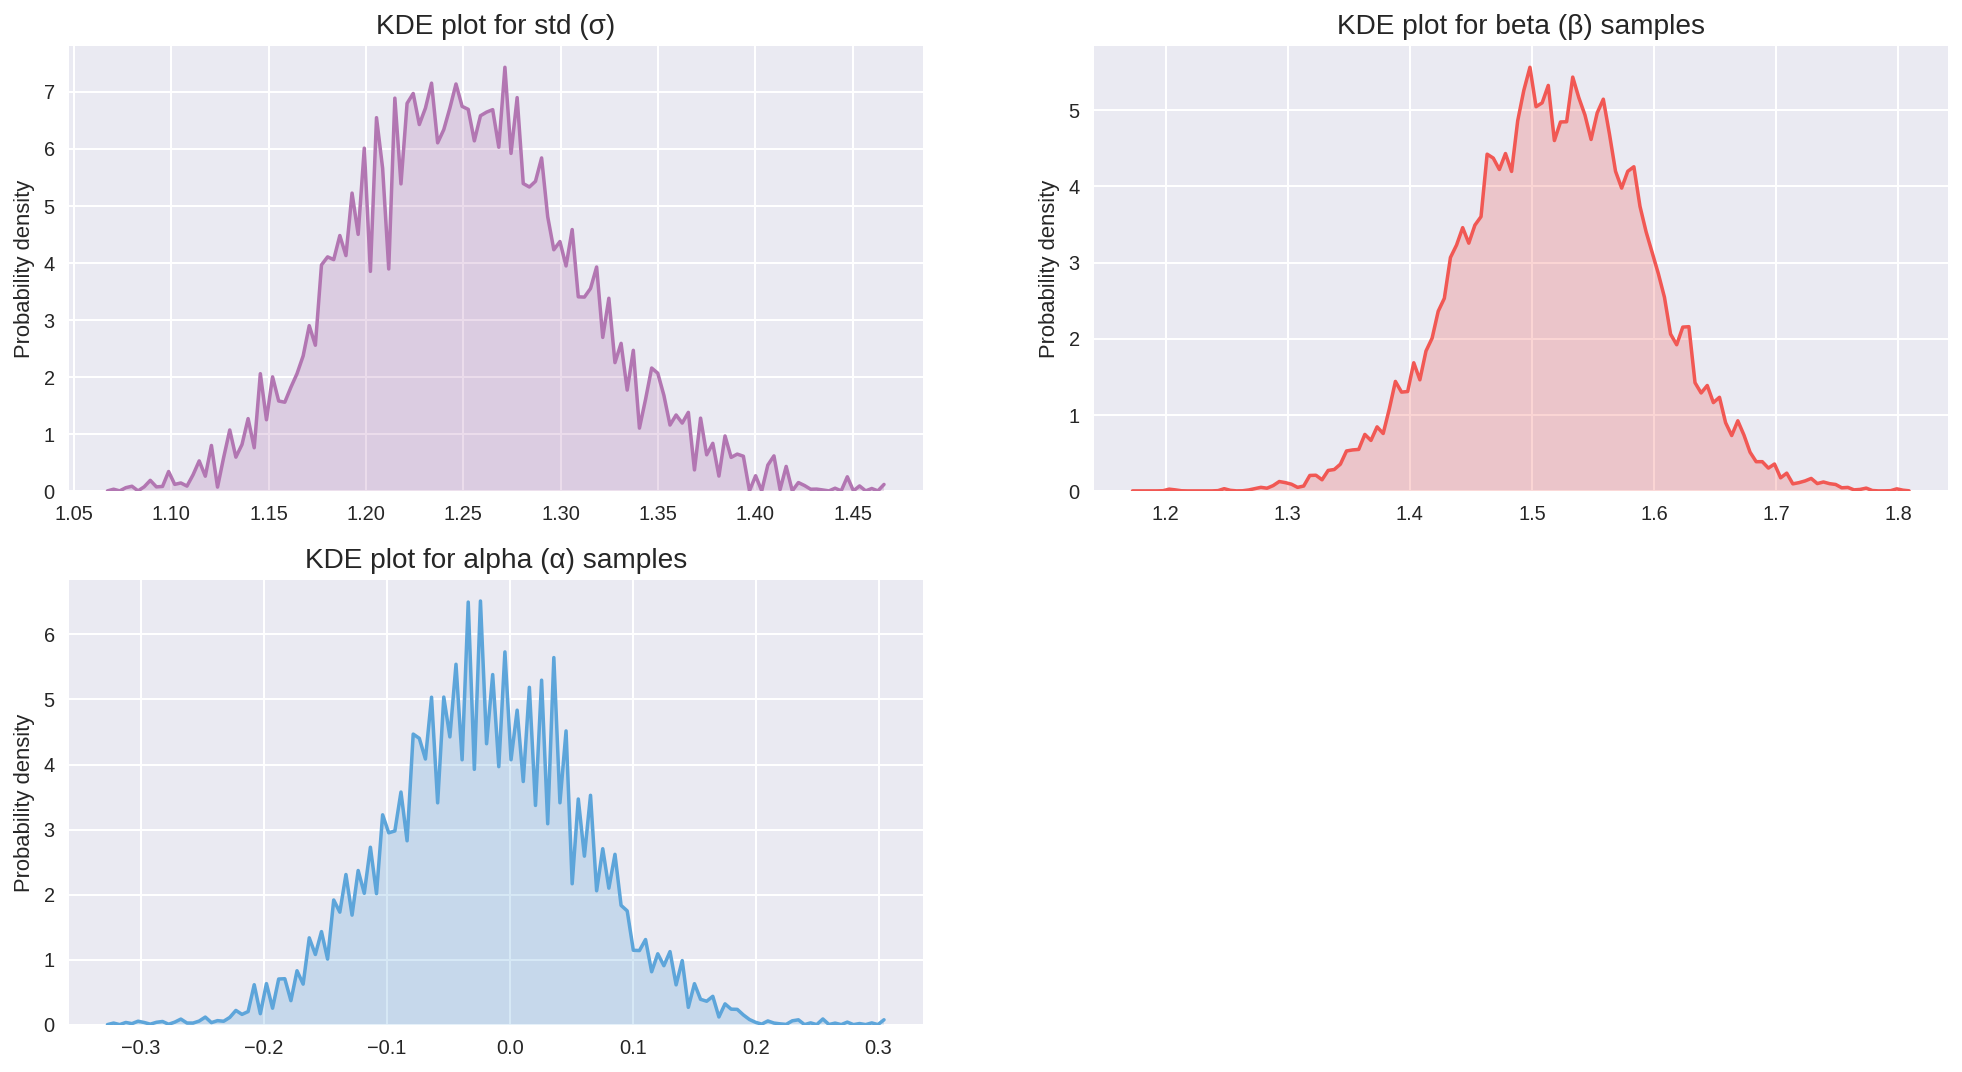

In [17]:
# plotting the Posterior Samples

plt.figure(figsize=(15,12))
plt.subplot(3, 2, 1)
plt.hist(sigma_, 
         bins=100, color=TFColor[6], alpha=0.8)
plt.ylabel('Frequency')
plt.title('posterior sigma (σ) samples', fontsize=14)


plt.subplot(3, 2, 3)
plt.hist(beta_, 
         bins=100, color=TFColor[0], alpha=0.8)
plt.ylabel('Frequency')
plt.title('posterior beta (β) samples', fontsize=14)


plt.subplot(3, 2, 5)
plt.hist(alpha_, bins=100, 
         color=TFColor[3], alpha=0.8)
plt.ylabel('Frequency')
plt.title('posterior alpha (α) samples', fontsize=14)


#KDE Plots
warnings.filterwarnings("ignore", category=DeprecationWarning)
plt.figure(figsize=(15,9))
plt.subplot(2, 2, 1)
ax1 = sns.kdeplot(sigma_, 
                  shade=True, color=TFColor[6], bw=.000075)
plt.ylabel('Probability density')
plt.title('KDE plot for std (σ)', fontsize=14)
plt.subplot(2, 2, 2)
ax2 = sns.kdeplot(beta_, 
                  shade=True, color=TFColor[0], bw=.0030)
plt.ylabel('Probability density')
plt.title('KDE plot for beta (β) samples', fontsize=14)
plt.subplot(2, 2, 3)
ax3 = sns.kdeplot(alpha_, 
                  shade=True, color=TFColor[3], bw=.0001)
plt.ylabel('Probability density')
plt.title('KDE plot for alpha (α) samples', fontsize=14)